# Week03 - DL Basic

## [Day 11] - 딥러닝 기초

## Multi-Layer Perceptron, MLP

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Pytorch version: {}".format(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

Pytorch version: 1.8.1
device: cpu


### 0. Dataset

In [7]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...

Done!


/Users/jinseok/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor()

### 1. Transform to Iterator

In [11]:
BATCH_SIZE = 256
train = torch.utils.data.DataLoader(
                                      mnist_train
                                    , batch_size = BATCH_SIZE
                                    , shuffle = True
                                    , num_workers = 5
)

test = torch.utils.data.DataLoader(
                                      mnist_test
                                    , batch_size = BATCH_SIZE
                                    , shuffle = True
                                    , num_workers = 5
)

### 2. Model (MLP)

In [13]:
nn.Module

torch.nn.modules.module.Module

In [20]:
class MLP(nn.Module):
    
    def __init__(self, name = 'mlp', xdim = 784, hdim = 256, ydim = 10):
        super(MLP, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.fst_layer = nn.Linear(
                                      self.xdim
                                    , self.hdim
        )
        self.snd_layer = nn.Linear(
                                      self.hdim
                                    , self.ydim
        )
        self.init_param()
        
    def init_param(self):
        # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
        nn.init.kaiming_normal_(self.fst_layer.weight)
        nn.init.zeros_(self.fst_layer.bias)
        nn.init.kaiming_normal_(self.snd_layer.weight)
        nn.init.zeros_(self.snd_layer.bias)
        
    def forward(self, x):
        x = x
        x = self.fst_layer(x)
        x = F.relu(x)
        x = self.snd_layer(x)
        return x

In [30]:
def Evaluate(model, dataloader, device):
    with torch.no_grad():
        model.eval()
        n_total, n_correct = 0,0
        for batch_in, batch_out in dataloader:
            y_trgt = batch_out.to(device)
            
            pred = model(
                batch_in.view(-1, 28*28).to(device)
            )
            _, y_pred = torch.max(pred.data, 1)
            
            n_correct += (
                y_pred == y_trgt
            ).sum().item()
            
            n_total += batch_in.size(0)
            
        val_accr = (n_correct / n_total)
        model.train()
    return val_accr

In [21]:
model = MLP(
              name = 'mlp'
            , xdim = 784
            , hdim = 256
            , ydim = 10
).to(device)

loss = nn.CrossEntropyLoss()
optm = optim.Adam(model.parameters(), lr = 0.001)

### 3. Train & Test

In [35]:
# 학습 전, 초기 파라미터의 모델 성능
model.init_param()
train_accr = Evaluate(model, train, device)
test_accr = Evaluate(model, test, device)
print ("train_accr: {} test_accr: {}".format(train_accr, test_accr))

train_accr: 0.12771666666666667 test_accr: 0.1296


In [36]:
# 학습

In [44]:
model.init_param()
model.train()

EPOCHS = 10

for eph in range(EPOCHS):
    total_loss = 0
    
    for batch_in, batch_out in train:
        
        y_pred = model.forward(batch_in.view(-1, 28*28).to(device))
        per_loss = loss(y_pred, batch_out.to(device))
        
        optm.zero_grad()
        per_loss.backward()
        optm.step()
        total_loss += per_loss
        
    avg_loss = total_loss / len(train)
    
    train_acc = Evaluate(model, train, device)
    test_acc = Evaluate(model, test, device)
    
    print(f'epoch: {eph + 1}  loss: {avg_loss:.3f}  train_acc: {train_acc:.3f}  test_acc: {test_acc:.3f}')

epoch: 1  loss: 0.299  train_acc: 0.957  test_acc: 0.956
epoch: 2  loss: 0.134  train_acc: 0.971  test_acc: 0.964
epoch: 3  loss: 0.098  train_acc: 0.976  test_acc: 0.968
epoch: 4  loss: 0.076  train_acc: 0.983  test_acc: 0.973
epoch: 5  loss: 0.060  train_acc: 0.986  test_acc: 0.975
epoch: 6  loss: 0.050  train_acc: 0.988  test_acc: 0.975
epoch: 7  loss: 0.042  train_acc: 0.992  test_acc: 0.977
epoch: 8  loss: 0.035  train_acc: 0.994  test_acc: 0.979
epoch: 9  loss: 0.029  train_acc: 0.995  test_acc: 0.979
epoch: 10  loss: 0.024  train_acc: 0.995  test_acc: 0.978


### 4. Test Sample

In [51]:
n = 25
sample = np.random.choice(len(mnist_test.targets), n, replace = False)

sample_x = mnist_test.data[sample]
sample_y = mnist_test.targets[sample]

with torch.no_grad():
    # 해당 과정에서 갑자기 .type(torch.float) 으로 되는 이유는 input 데이터가 dataloader 일 때와 형태가 다르기 때문
    y_pred = model.forward(sample_x.view(-1, 28*28).type(torch.float).to(device) / 255)

In [76]:
for batch_in, _ in train:
    break
    
type(batch_in), type(sample_x)

(torch.Tensor, torch.Tensor)

In [77]:
batch_in[0][0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [78]:
sample_x[0][0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)

In [66]:
model.forward(batch_in.view(-1, 28*28).to(device))

tensor([[ -4.0110,  -7.2873,  -4.1383,  ...,   0.6805,  -0.6500,   4.2553],
        [ -1.9987,  -5.3654,  -0.9776,  ...,  11.0756,  -0.1557,   3.4649],
        [ -8.8585,  -1.4046,   0.1573,  ..., -10.9951,   2.9648,  -4.5479],
        ...,
        [ -6.1302,  -6.5344,  -2.2801,  ...,  -3.1403,  -2.8020,  -0.5649],
        [  2.3779,  -3.1599,  -4.2286,  ...,   7.6854,  -3.3579,   1.8294],
        [ -2.9787,  -6.0937,   2.7032,  ...,  -8.9899,  -6.8611, -13.7900]],
       grad_fn=<AddmmBackward>)

In [67]:
# float 형태가 아닌 byte 형태이기 때문에 모델이 읽지 못함
model.forward(sample_x.view(-1, 28*28).to(device))

RuntimeError: expected scalar type Float but found Byte

In [54]:
# sample prediction
y_pred = y_pred.argmax(axis = 1)

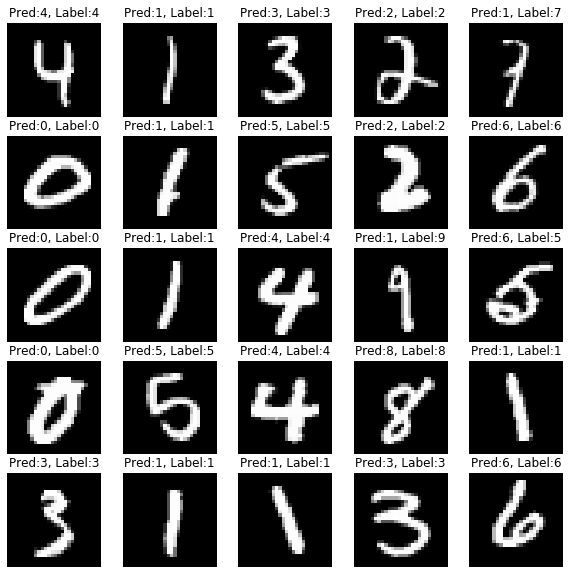

In [79]:
plt.figure(figsize = (10, 10))
for idx in range(n):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(sample_x[idx], cmap = 'gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],sample_y[idx]))
plt.show()    